In [32]:
# 1. Librerías y configuración de gráficas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (11, 6)

In [33]:
# 2. Cargar el CSV
df = pd.read_csv("resultado_simulacion_todos_los_dias.csv")

In [34]:
# 3. Limpieza mínima y columnas auxiliares
# Ganador de la hora
def ganador(row):
    if row["acepta_solar"] and not row["acepta_eolico"]:
        return "Solar"
    if row["acepta_eolico"] and not row["acepta_solar"]:
        return "Eólico"
    if row["acepta_solar"] and row["acepta_eolico"]:
        return "Empate"
    return "Ninguno"

df["ganador"] = df.apply(ganador, axis=1)

# Eficiencia: fracción cubierta / demanda
df["entregado_total"] = df["energia_solar"] + df["energia_eolico"]
df["eficiencia"] = (df["demanda_wh"] - df["restante_wh"]) / df["demanda_wh"]

In [35]:
# 4. Métricas globales (con display)
from IPython.display import display

# 4.1 Ganador global
tabla_ganador = (
    df["ganador"]
    .value_counts()
    .rename_axis("Ganador")
    .reset_index(name="Frecuencia")
)
display(tabla_ganador.style.set_caption("Ganador global"))

# 4.2 Cobertura promedio
tabla_cobertura = pd.DataFrame(
    {"Cobertura_promedio": [df["eficiencia"].mean()]}
)
display(tabla_cobertura.style.set_caption("Cobertura promedio"))

# 4.3 Precio medio por fuente
tabla_precios = (
    df[["precio_solar", "precio_eolico"]]
    .mean()
    .to_frame(name="€/Wh")
    .rename_axis("Fuente")
    .reset_index()
)
display(tabla_precios.style.set_caption("Precio medio (€/Wh)"))


,Ganador,Frecuencia
0,Solar,5353
1,Empate,1771
2,Eólico,1004


,Cobertura_promedio
0,0.984447


,Fuente,€/Wh
0,precio_solar,16.829515
1,precio_eolico,15.740226


ganador,Empate,Eólico,Solar
estr_solar,,,
bluffing,568,260,1900
hide,639,419,1692
reveal,564,325,1761


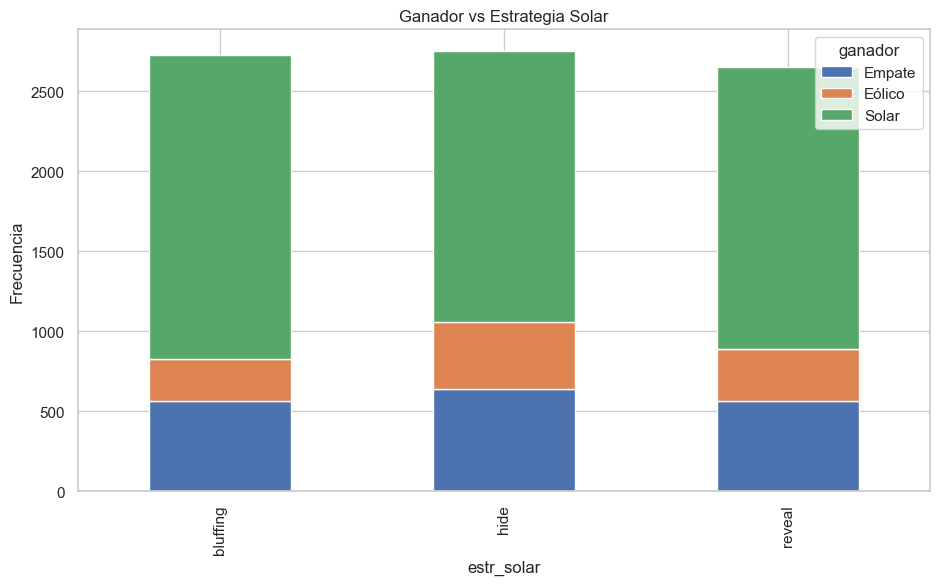

In [36]:
# 5. Ganador por estrategia del consumidor
tabla_estrategia = df.groupby("estr_solar")["ganador"].value_counts().unstack(fill_value=0)
display(tabla_estrategia)

# Gráfico
tabla_estrategia.plot(kind="bar", stacked=True)
plt.title("Ganador vs Estrategia Solar")
plt.ylabel("Frecuencia")
plt.show()

ganador,Empate,Eólico,Solar
periodo,,,
dia,65,98,4235
noche,1706,906,1118


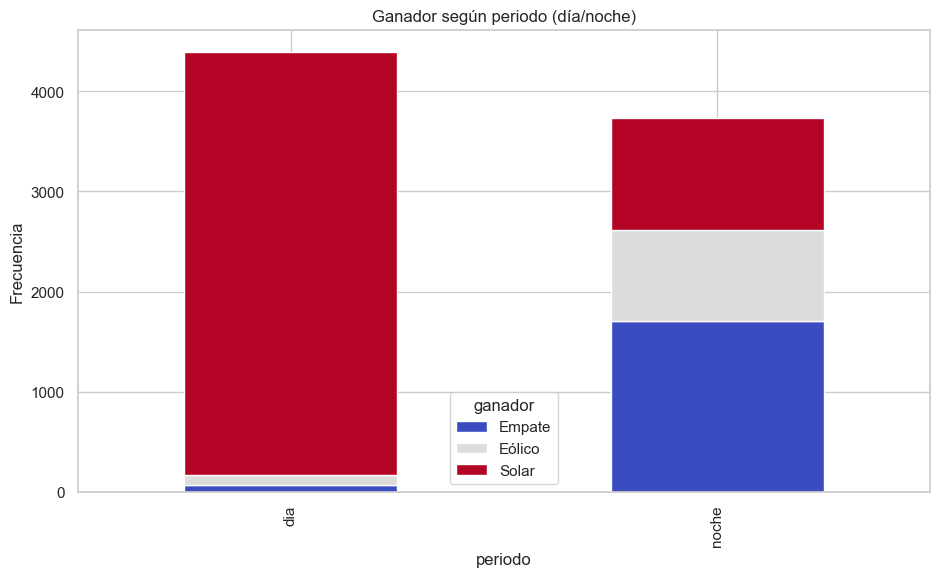

Cobertura media día/noche:
periodo
dia      0.997
noche    0.969
Name: eficiencia, dtype: float64 



In [37]:
# 6. Ganador por día vs noche
tabla_periodo = df.groupby("periodo")["ganador"].value_counts().unstack(fill_value=0)
display(tabla_periodo)

tabla_periodo.plot(kind="bar", stacked=True, colormap="coolwarm")
plt.title("Ganador según periodo (día/noche)")
plt.ylabel("Frecuencia")
plt.show()

# Cobertura media día/noche
efic_periodo = df.groupby("periodo")["eficiencia"].mean().round(3)
print("Cobertura media día/noche:")
print(efic_periodo, "\n")

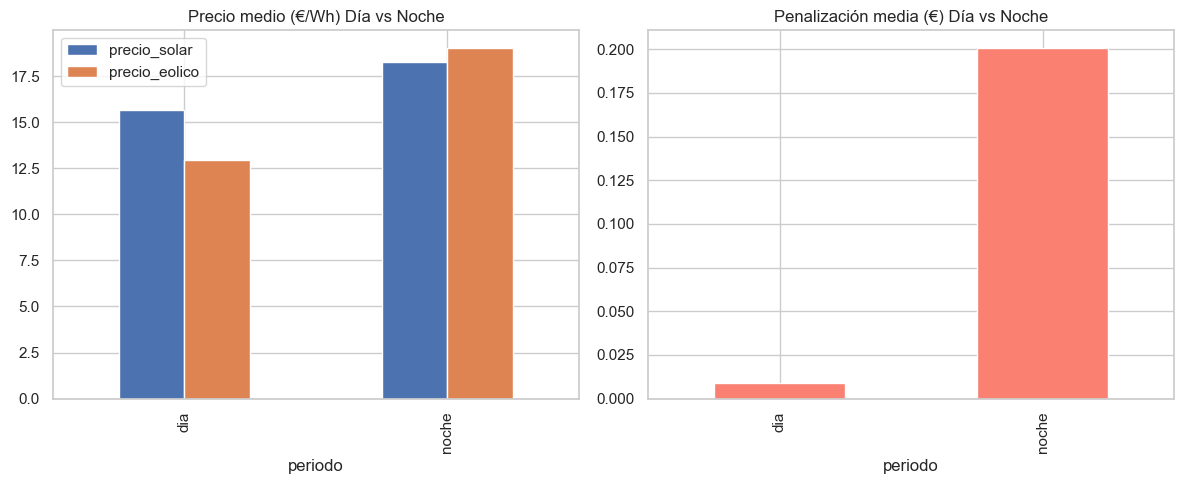

In [38]:
# 7. Precios y penalizaciones por periodo
precio_periodo = df.groupby("periodo")[["precio_solar", "precio_eolico"]].mean()
penal_periodo  = df.groupby("periodo")["penalizacion"].mean()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
precio_periodo.plot(kind="bar", ax=ax[0])
ax[0].set_title("Precio medio (€/Wh) Día vs Noche")

penal_periodo.plot(kind="bar", color="salmon", ax=ax[1])
ax[1].set_title("Penalización media (€) Día vs Noche")
plt.tight_layout()
plt.show()

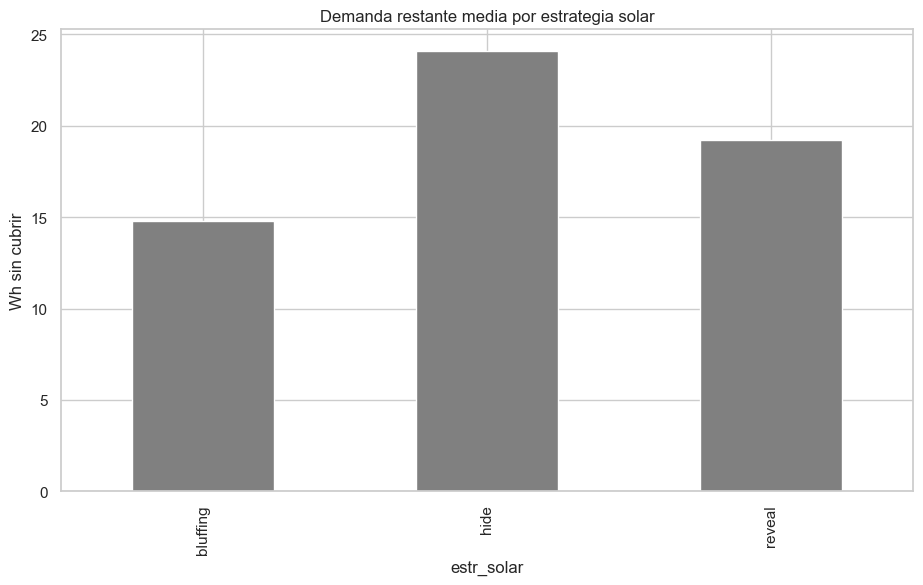

In [39]:
# 8. Desperdicio de energía (restante) por estrategia
restante_estr = df.groupby("estr_solar")["restante_wh"].mean()
restante_estr.plot(kind="bar", color="gray")
plt.title("Demanda restante media por estrategia solar")
plt.ylabel("Wh sin cubrir")
plt.show()


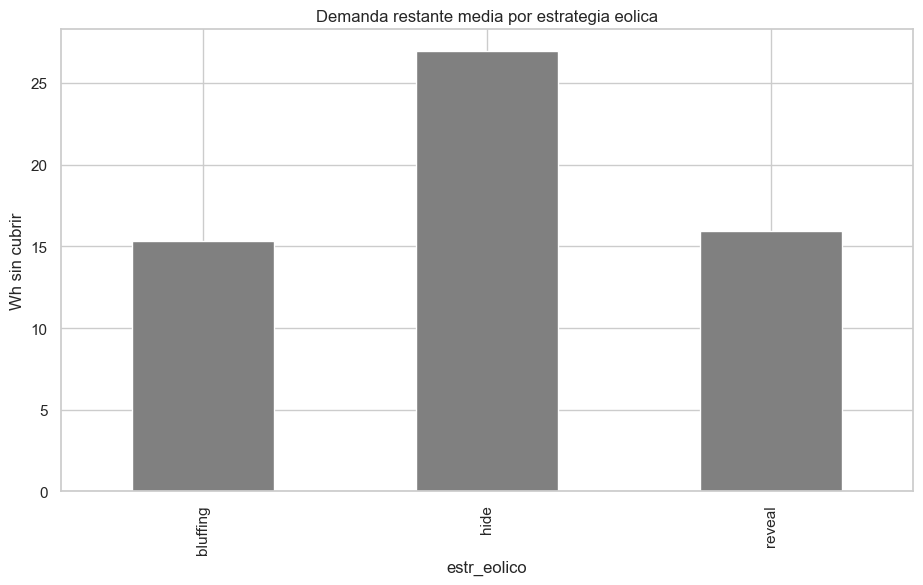

In [40]:
# 8. Desperdicio de energía (restante) por estrategia
restante_estr = df.groupby("estr_eolico")["restante_wh"].mean()
restante_estr.plot(kind="bar", color="gray")
plt.title("Demanda restante media por estrategia eolica")
plt.ylabel("Wh sin cubrir")
plt.show()

,energia_solar,energia_eolico,ganador_hora
hora,,,
0,401.630000,564.220000,eolico
1,377.210000,544.410000,eolico
2,387.900000,526.420000,eolico
3,408.240000,555.590000,eolico
4,452.610000,488.180000,eolico
5,377.160000,20.910000,solar
6,387.850000,17.280000,solar
7,372.940000,13.100000,solar
8,396.450000,9.290000,solar


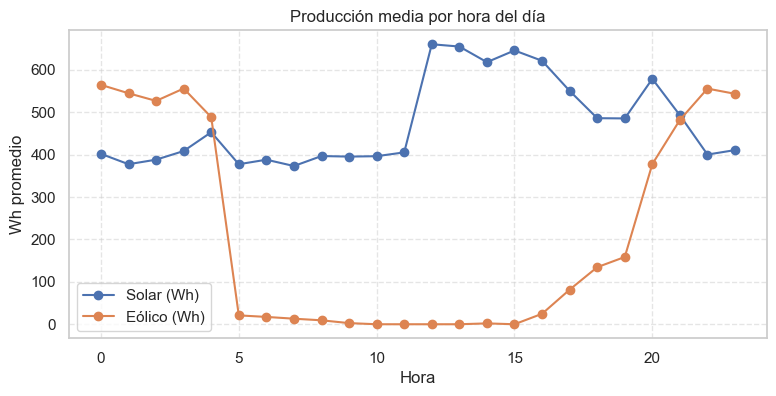

In [42]:
# Promedio de la energía por hora del día
prom = (
    df.groupby("hora")[["energia_solar", "energia_eolico"]]
      .mean()
      .round(2)
)

# Ganador de cada hora
prom["ganador_hora"] = (
    prom.apply(
        lambda r: (
            "solar"  if r["energia_solar"]  > r["energia_eolico"] + 1e-6 else
            "eolico" if r["energia_eolico"] > r["energia_solar"]  + 1e-6 else
            "empate"
        ),
        axis=1
    )
)

# 3. Top-3 de horas con más producción solar y top-3 eólica
top3_solar  = prom.nlargest(3, "energia_solar").index
top3_eolico = prom.nlargest(3, "energia_eolico").index

def color_top_rows(row):
    """Colorea filas: amarillo = top-3 solar, celeste = top-3 eólico."""
    if row.name in top3_solar:
        return ['background-color:#FFF59D'] * len(row)   # amarillo suave
    if row.name in top3_eolico:
        return ['background-color:#B3E5FC'] * len(row)   # celeste suave
    return [''] * len(row)

styled = prom.style.apply(color_top_rows, axis=1)

# Mostrar la tabla coloreada
display(styled)

# Gráfico comparativo por hora
plt.figure(figsize=(9, 4))
plt.plot(prom.index, prom["energia_solar"],  marker="o", label="Solar (Wh)")
plt.plot(prom.index, prom["energia_eolico"], marker="o", label="Eólico (Wh)")
plt.title("Producción media por hora del día")
plt.xlabel("Hora")
plt.ylabel("Wh promedio")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

